In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn joblib


Note: you may need to restart the kernel to use updated packages.


# 1)Imports & load data

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# load
df = pd.read_csv('C:\\Users\\akula\\Downloads\\Raji\\boston.csv')


# 2) Quick EDA / checks

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


<Axes: >

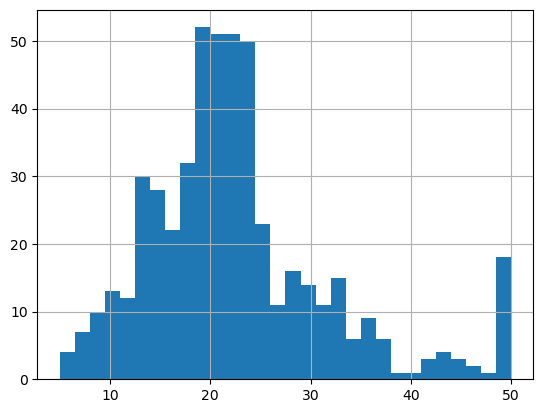

In [3]:
df.shape
df.head()
df.info()
df.describe().T
# count nulls
df.isnull().sum().sort_values(ascending=False).head(20)
# check skew of numeric cols
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols].skew().sort_values(ascending=False).head(20)
# visualize target distribution
df['MEDV'].hist(bins=30)


# 3) Detect target and separate X/y

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


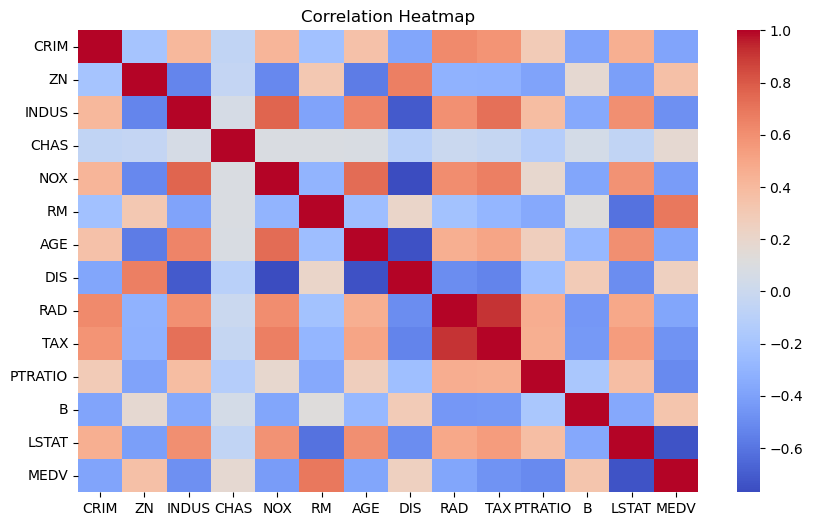

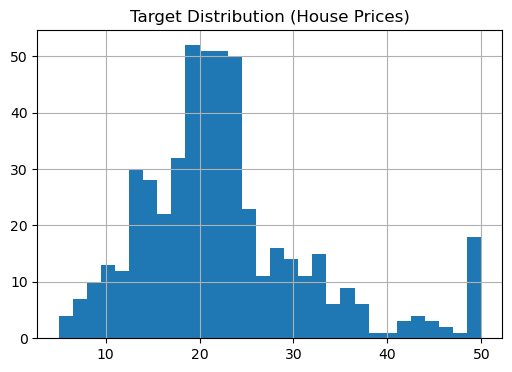

In [4]:
# Summary
display(df.describe().T)

# Check missing values
print(df.isnull().sum())

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Target distribution
df["MEDV"].hist(bins=30, figsize=(6,4))
plt.title("Target Distribution (House Prices)")
plt.show()


In [5]:
target = "MEDV"   # if Boston dataset
y = df[target].copy()
X = df.drop(columns=[target])

print("Target and features separated")
print("X shape:", X.shape)
print("y shape:", y.shape)



Target and features separated
X shape: (506, 13)
y shape: (506,)


# 4) Impute missing values

In [6]:
# numeric impute median
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# categorical impute most frequent
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
cat_imputer = SimpleImputer(strategy='most_frequent')
if cat_cols:
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

print("Missing values filled")
print("Remaining nulls per column:\n", X.isnull().sum().head())



Missing values filled
Remaining nulls per column:
 CRIM     0
ZN       0
INDUS    0
CHAS     0
NOX      0
dtype: int64


# 5)Encode categorical features

In [7]:
from sklearn.preprocessing import LabelEncoder

# one-hot encoding
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("Encoding done")
print("Shape after encoding:", X.shape)
print("Example columns:", list(X.columns[:10]))



Encoding done
Shape after encoding: (506, 13)
Example columns: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX']


# 6) Detect & log-transform skewed numeric features (np.log1p)

In [8]:
skewness = X[num_cols].skew().abs().sort_values(ascending=False)
skew_threshold = 0.75
skewed_cols = skewness[skewness > skew_threshold].index.tolist()

# apply log1p
for c in skewed_cols:
    X[c] = np.log1p(X[c])

print("Log transform applied to skewed columns")
print("Skewed columns:", skewed_cols[:10])  # show a few



Log transform applied to skewed columns
Skewed columns: ['CRIM', 'CHAS', 'B', 'ZN', 'DIS', 'RAD', 'LSTAT', 'PTRATIO']


# 7) Train/Test split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)





Train: (404, 13) Test: (102, 13)


# 8) Train a baseline model (Random Forest)

In [15]:
print("Data ready for model training (no scaling needed for RandomForest)")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)



Data ready for model training (no scaling needed for RandomForest)
Train shape: (404, 13) Test shape: (102, 13)


# 9) Evaluate the model (RMSE, R², CV)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train directly on unscaled data
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Model training completed")

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model evaluation results:")
print("MSE :", mse)
print("RMSE:", rmse)
print("R²  :", r2)




Model training completed
Model evaluation results:
MSE : 7.9391137549019595
RMSE: 2.817643298024425
R²  : 0.8917400219548827


# 10) Feature importance (RandomForest)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 Important Features:")
print(feat_imp.head(10))

feat_imp.head(20).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.show()



# 11) Save model, scaler and metadata

In [ ]:
import joblib

artifact = {
    'model': model,
    'scaler': scaler,
    'num_imputer': num_imputer,
    'cat_imputer': cat_imputer,
    'features': X.columns.tolist()
}
joblib.dump(artifact, 'house_price_model.pkl')
print("Model pipeline saved as house_price_model.pkl")


